In [4]:
import matplotlib
matplotlib.rcParams['figure.figsize'] = (20, 15)

#  3.- Calidad de un vino


El objetivo corresponde a predecir la calidad observada por los consumidores de un vino en particular, utilizando un dataset de distintos vinos con distintos atributos químicos que han sido evaluados anteriormente.

## Descripción del dataset

Primero, se carga el dataset dentro de un DataFrame de Pandas para describirlo y visualizar su distribución

In [2]:
import pandas as pd
df_red = pd.read_csv("data/winequality-red.csv",sep=";")
df_white = pd.read_csv("data/winequality-white.csv",sep=";")

# Add the type column
df_red['type'] = 1
df_white['type'] = 0
df = pd.concat([df_red,df_white], axis=0)
df.describe()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality,type
count,6497.000000,6497.000000,6497.000000,6497.000000,6497.000000,6497.000000,6497.000000,6497.000000,6497.000000,6497.000000,6497.000000,6497.000000,6497.000000
mean,7.215307,0.339666,0.318633,5.443235,0.056034,30.525319,115.744574,0.994697,3.218501,0.531268,10.491801,5.818378,0.246114
std,1.296434,0.164636,0.145318,4.757804,0.035034,17.749400,56.521855,0.002999,0.160787,0.148806,1.192712,0.873255,0.430779
min,3.800000,0.080000,0.000000,0.600000,0.009000,1.000000,6.000000,0.987110,2.720000,0.220000,8.000000,3.000000,0.000000
25%,6.400000,0.230000,0.250000,1.800000,0.038000,17.000000,77.000000,0.992340,3.110000,0.430000,9.500000,5.000000,0.000000
50%,7.000000,0.290000,0.310000,3.000000,0.047000,29.000000,118.000000,0.994890,3.210000,0.510000,10.300000,6.000000,0.000000
75%,7.700000,0.400000,0.390000,8.100000,0.065000,41.000000,156.000000,0.996990,3.320000,0.600000,11.300000,6.000000,0.000000
max,15.900000,1.580000,1.660000,65.800000,0.611000,289.000000,440.000000,1.038980,4.010000,2.000000,14.900000,9.000000,1.000000


Las variables de entrada utilizadas se basan en pruebas fisioquímicas de los vinos y corresponden a:
* 1 - fixed acidity: Acidez volátil
* 2 - volatile acidity: Acidez volátil
* 3 - citric acid: Acidez cítrica
* 4 - residual sugar: Azúcar residual
* 5 - chlorides: Cloros
* 6 - free sulfur dioxide: Dioxidos de sulfuro libres
* 7 - total sulfur dioxide: Dioxidos de sulfuro totales
* 8 - density: Densidad
* 9 - pH: pH
* 10 - sulphates: Cantidad de Sulfatos
* 11 - alcohol: Cantidad de alcohol
* 12 - type: Tipo de vino (generado para diferenciar). 1 es vino tinto y 0 es vino blanco
   
Y por último se tiene la variable de salida que es la calidad de los vinos que tiene un puntaje entre 0 y 10, siendo 0 la peor calidad y 10 la mejor calidad.
* 13 - quality (score between 0 and 10)

Por último, se tiene un total de 6497 vinos en el dataset

A continuación se visualizan los datos:

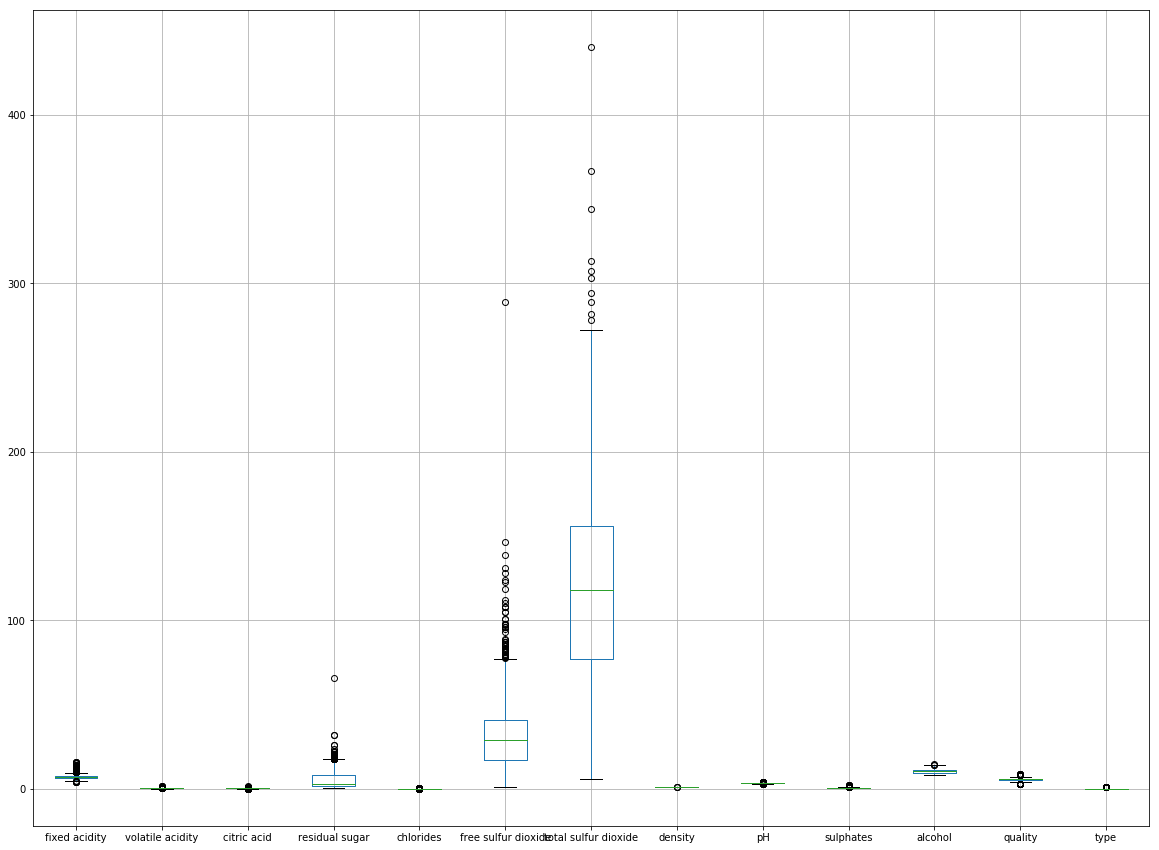

In [5]:
import matplotlib.pyplot as plt
df.boxplot()
plt.show()

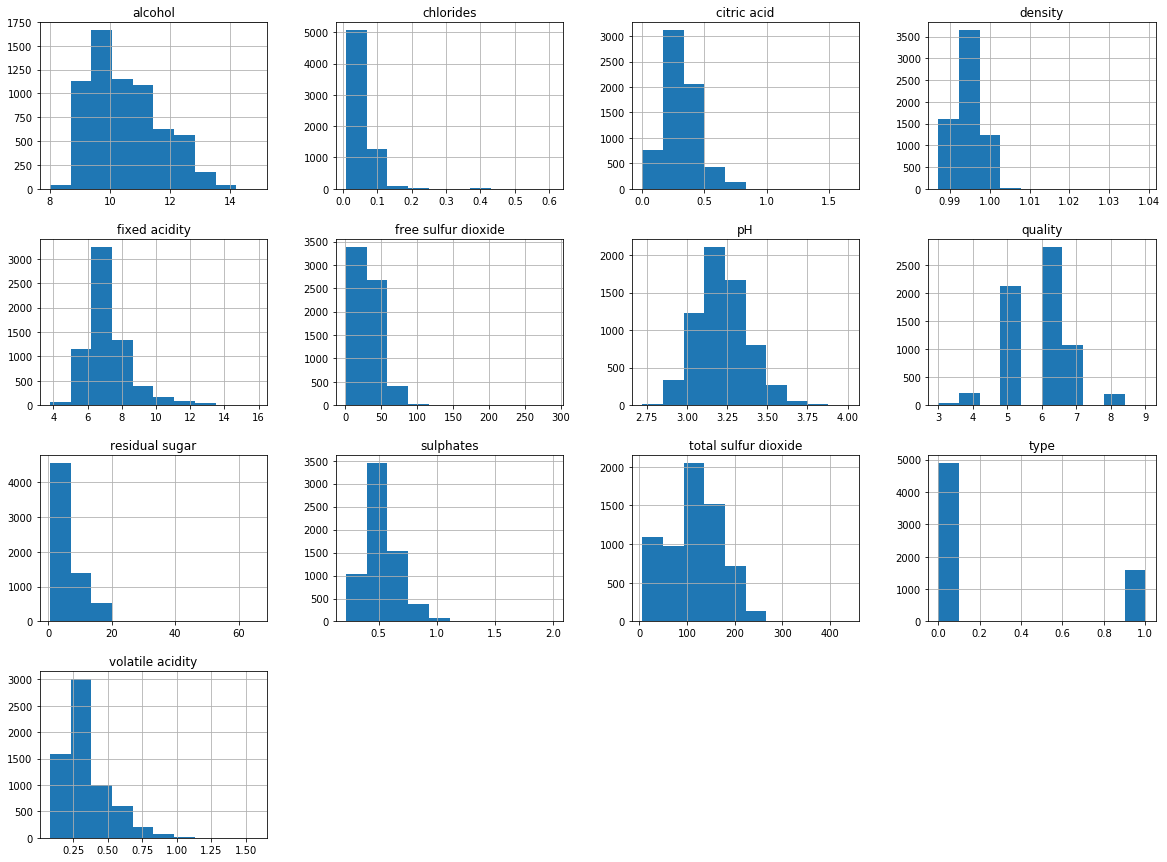

In [6]:
import matplotlib.pyplot as plt
import matplotlib
df.hist()
plt.show()

Se puede notar la existencia de una gran cantidad de datos outliers en el dataset que son necesarios para lograr hacer que las máquinas reconozcan cómo valores absurdos de las variables afectan la calidad de los vinos. Por tanto, no se eliminarán

## Procesamiento de dataset

Se abordará el problema como uno de clasificación binaria para decidir si un vino es de buena calidad o no. Para esto, se tiene que una calidad mayor a 5 es considerado un vino de buena calidad.

Antes de realizar el entrenamiento, se realizará un procesamiendo del dataset en dónde se reordenarán aleatoriamente los datos de entrada y normalizarán todos los atributos para facilitar el proceso mismo de entrenamiento. La normalización a utilizar corresponde solo a una conversión de tipo MinMax en dónde el mínimo valor posible es de 0 y el mayor de 1.

Se dividira el dataset entre un 50% para entrenamiento, un 25% para testing y un 25% para validación

In [7]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

# Reemplazo de quality por good quality
df['good_quality'] = [1 if q > 5 else 0 for q in df.quality]
df = df.drop('quality', axis=1)

# Reordenamiento aleatorio
df_randomized = df.sample(frac=1, random_state=3850)

# Normalización
scaler = MinMaxScaler()
cols = df_randomized.columns.tolist()
cols.remove('good_quality')
df_randomized[cols] = scaler.fit_transform(df_randomized[cols])

# División
(Xtrain, X_general_tests) = train_test_split(df_randomized, test_size=0.5, random_state=8500)
(Xvalidation, Xtest) = train_test_split(X_general_tests, test_size=0.5, random_state=10500)

Ytrain = Xtrain['good_quality']
Ytest = Xtest['good_quality']
Yvalidation = Xvalidation['good_quality']

Xtrain = Xtrain.drop('good_quality', axis=1)
Xtest = Xtest.drop('good_quality', axis=1)
Xvalidation = Xvalidation.drop('good_quality', axis=1)

## Arbol de clasificación

A continuación se entrena un árbol de clasificación para resolver el problema de predecir si la calidad de un vino es buena o no.

Para ver el efecto de la máxima profundidad del árbol, se varía el parámetro de forma arbitraria entre 1 y 20 niveles de profundida máximos. Los resultados son los siguientes:

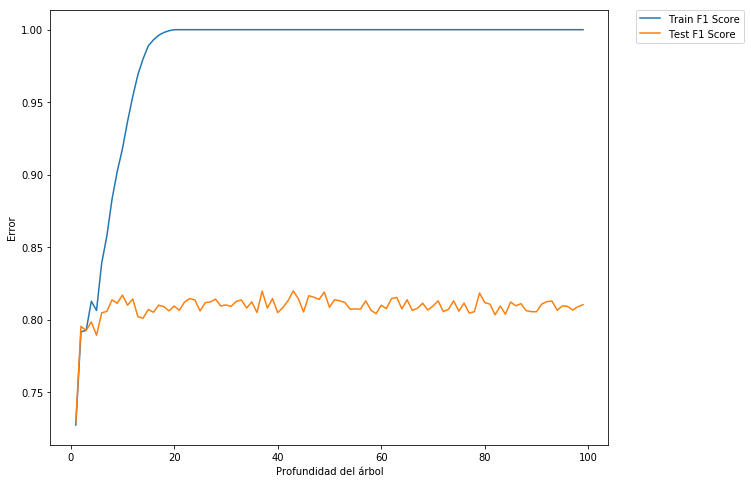

In [8]:
from sklearn.tree import DecisionTreeClassifier as Tree
from sklearn.metrics import accuracy_score
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score

def train_tree(depth, Xtrain, Ytrain, Xtest, Ytest):
    # Entrenar el árbol
    model = Tree()
    model.set_params(max_depth=depth, criterion='gini', splitter='best')
    model.fit(Xtrain, Ytrain)

    Ytrain_pred = model.predict(Xtrain)
    Ytest_pred = model.predict(Xtest)


    train_error = (1-accuracy_score(Ytrain, Ytrain_pred))
    test_error = (1-accuracy_score(Ytest, Ytest_pred))
    train_f1 = f1_score(Ytrain, Ytrain_pred)
    test_f2 = f1_score(Ytest, Ytest_pred)

    return (train_error, test_error, train_f1, test_f2)

def graph_tree_range(params):
    train_errors = []
    test_errors = []
    f1_train_errors = []
    f1_test_errors = []

    for depth in params:
        (train, test, f1train, f1test) = train_tree(depth, Xtrain, Ytrain, Xtest, Ytest)
        train_errors.append(train)
        test_errors.append(test)
        f1_train_errors.append(f1train)
        f1_test_errors.append(f1test)

    plt.figure(figsize=(10, 8))
    plt.plot(params, f1_train_errors, label="Train F1 Score")
    plt.plot(params, f1_test_errors, label="Test F1 Score")
    plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
    plt.xlabel('Profundidad del árbol')
    plt.ylabel('Error')
    plt.show()
    
params = np.arange(1, 100, 1)
graph_tree_range(params)



Haciendo "zoom" hacia valores pequeños de profundidad tenemos

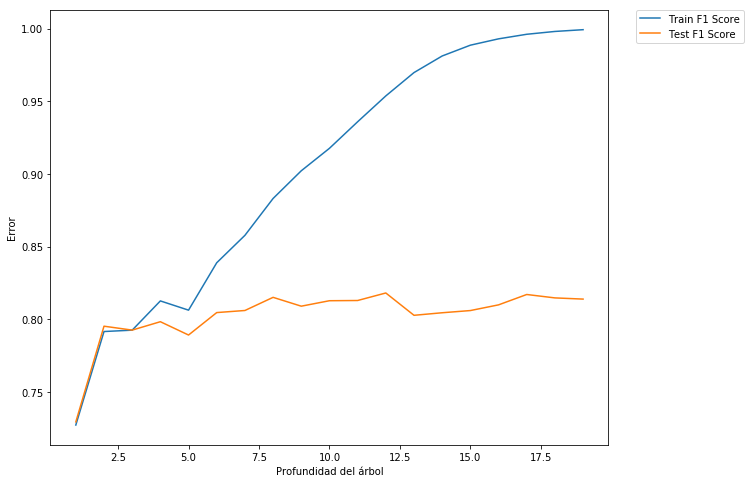

In [9]:
params = np.arange(1, 20, 1)
graph_tree_range(params)

Se puede notar que una vez que se alcanza una profundidad aproximada de 20 hijos en el árbol, el error de entrenamiento tiende a 0 y el error de testing no sufre mayores cambios. Para evitar computaciones extras, es mejor utilizar esta profunidad.

El puntaje para el árbol de clasificación es entonces alrededor de 83%.

## Ensamblador de árboles de múltiples niveles (Random Forest)

Para demostrar el poder del aprendizaje por ensamblado, se utilizará uno de árboles de múltiples niveles que implementa la técnica de Random Forest en donde se crean una serie de arboles no relacionados que luego son promediados para obtener la predicción.

A continuación se construye y grafica el puntaje obtenido por esta máquina de aprendizaje según como se van variando los parámetros de profundidad del árbol y el número de árboles a utilizar por random forest

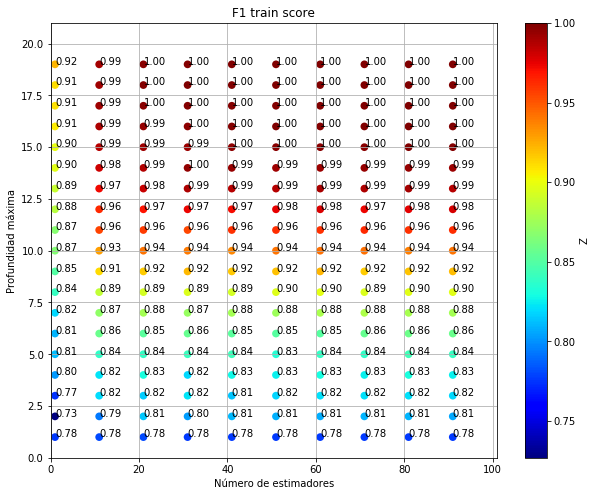

In [10]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score

def train_random_forest(estimators, depth, Xtrain, Ytrain, Xtest, Ytest):
    # Entrenar el árbol
    model = RandomForestClassifier(n_estimators=estimators, max_depth=depth,n_jobs=-1)
    model.fit(Xtrain, Ytrain)

    Ytrain_pred = model.predict(Xtrain)
    Ytest_pred = model.predict(Xtest)


    train_error = (1-accuracy_score(Ytrain, Ytrain_pred))
    test_error = (1-accuracy_score(Ytest, Ytest_pred))
    train_f1 = f1_score(Ytrain, Ytrain_pred)
    test_f2 = f1_score(Ytest, Ytest_pred)

    return (train_error, test_error, train_f1, test_f2)

def graph_random_forest_range(estimator_params, depth_params, z_to_show, upper_estimator, upper_depth):
    
    points = []
    for a in estimator_params:
        for b in depth_params:
            points.append((a, b))
        
    
    train_errors = []
    test_errors = []
    f1_train_errors = []
    f1_test_errors = []

    for point in points:
        (train, test, f1train, f1test) = train_random_forest(point[0], point[1], Xtrain, Ytrain, Xtest, Ytest)
        train_errors.append(train)
        test_errors.append(test)
        f1_train_errors.append(f1train)
        f1_test_errors.append(f1test)
        
    x = []
    y = []
    z1 = []
    z2 = []
    
    for pt in points:
        index = points.index(pt)
        x.append(pt[0])
        y.append(pt[1])
        z1.append(f1_train_errors[index])
        z2.append(f1_test_errors[index])
        
    z = None
    if z_to_show == 0:
        z = z1
    else:
        z = z2
    
        

    fig = plt.figure(figsize=(10, 8))
    ax = fig.add_subplot(1, 1, 1)
    cmap = matplotlib.cm.get_cmap("jet")
    pts = ax.scatter(x, y, s=60, c=z, cmap=cmap, 
                 linewidth=0)
    cbar = fig.colorbar(pts, ax=ax)
    fig.axes[-1].set_ylabel("Z")

    ax.grid()

    ax.set_xlabel("Número de estimadores")
    ax.set_ylabel("Profundidad máxima")
    ax.set_xlim(0, upper_estimator + 1)
    ax.set_ylim(0, upper_depth + 1)
    if z_to_show == 0:
        ax.set_title("F1 train score")
    else:
        ax.set_title("F1 test score")
        
    for i, txt in enumerate(z):
        ax.annotate("{0:.2f}".format(txt), (x[i],y[i]))
    
    plt.show()
    
estimator_params = np.arange(1, 100, 10)
depth_params = np.arange(1, 20, 1)
graph_random_forest_range(estimator_params, depth_params, 0, 100, 20)

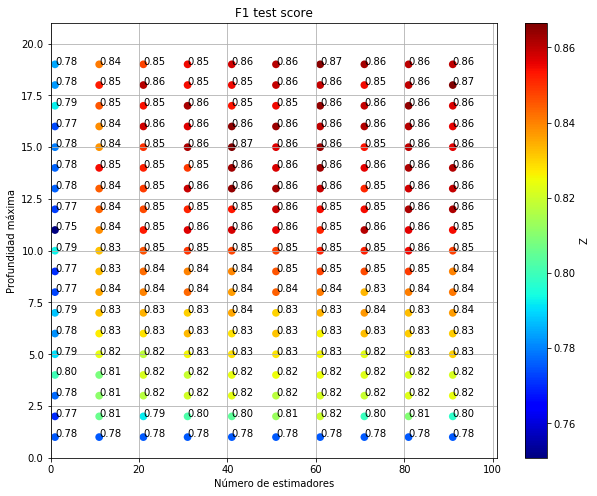

In [11]:
graph_random_forest_range(estimator_params, depth_params, 1, 100, 20)

El puntaje más alto sobre el conjunto de testing corresponde a 0.88 y ocurre con alrededor de 90 estimadores y una profundidad superior a 15.

Se puede observar que el mayor impacto sobre el error de testing corresponde a la profunidad de los árboles utilizados en random forest. Como el puntaje del conjunto de entrenamiento es casi 1, no es posible obtener mejor resultados que el error anterior.

## Ensamblador de árboles de múltiples niveles (AdaBoost)

A diferencia de Random Forest, Ada Boost se enfoca en aquellas instancias que son "difíciles", es decir, que tienen mayor error de clasificación.

El algoritmo no funciona correctamente cuando hay mucho ruido en el conjunto de datos y Random Forest tiende a ser mejo en caso de que hubiese.

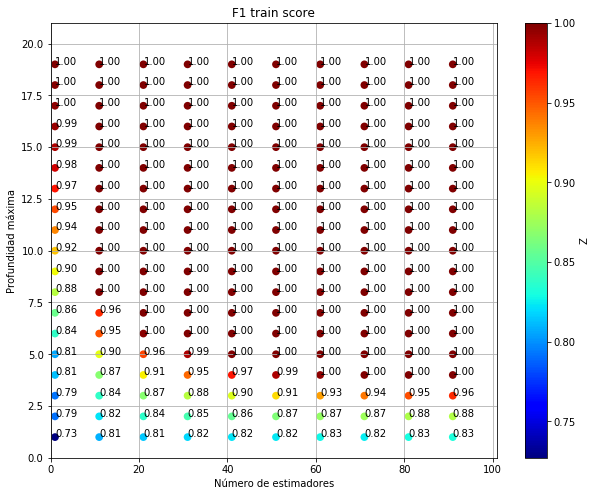

In [12]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.metrics import accuracy_score
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score

def train_ada_boost(estimators, depth, Xtrain, Ytrain, Xtest, Ytest):
    # Entrenar el árbol
    model = AdaBoostClassifier(base_estimator=Tree(max_depth=depth), n_estimators=estimators)
    model.fit(Xtrain, Ytrain)

    Ytrain_pred = model.predict(Xtrain)
    Ytest_pred = model.predict(Xtest)


    train_error = (1-accuracy_score(Ytrain, Ytrain_pred))
    test_error = (1-accuracy_score(Ytest, Ytest_pred))
    train_f1 = f1_score(Ytrain, Ytrain_pred)
    test_f2 = f1_score(Ytest, Ytest_pred)

    return (train_error, test_error, train_f1, test_f2)

def graph_ada_boost_range(estimator_params, depth_params, z_to_show, upper_estimator, upper_depth):
    
    points = []
    for a in estimator_params:
        for b in depth_params:
            points.append((a, b))
        
    
    train_errors = []
    test_errors = []
    f1_train_errors = []
    f1_test_errors = []

    for point in points:
        (train, test, f1train, f1test) = train_ada_boost(point[0], point[1], Xtrain, Ytrain, Xtest, Ytest)
        train_errors.append(train)
        test_errors.append(test)
        f1_train_errors.append(f1train)
        f1_test_errors.append(f1test)
        
    x = []
    y = []
    z1 = []
    z2 = []
    
    for pt in points:
        index = points.index(pt)
        x.append(pt[0])
        y.append(pt[1])
        z1.append(f1_train_errors[index])
        z2.append(f1_test_errors[index])
        
    z = None
    if z_to_show == 0:
        z = z1
    else:
        z = z2
    
        

    fig = plt.figure(figsize=(10, 8))
    ax = fig.add_subplot(1, 1, 1)
    cmap = matplotlib.cm.get_cmap("jet")
    pts = ax.scatter(x, y, s=60, c=z, cmap=cmap, 
                 linewidth=0)
    cbar = fig.colorbar(pts, ax=ax)
    fig.axes[-1].set_ylabel("Z")

    ax.grid()

    ax.set_xlabel("Número de estimadores")
    ax.set_ylabel("Profundidad máxima")
    ax.set_xlim(0, upper_estimator+1)
    ax.set_ylim(0, upper_depth+1)
    if z_to_show == 0:
        ax.set_title("F1 train score")
    else:
        ax.set_title("F1 test score")
        
    for i, txt in enumerate(z):
        ax.annotate("{0:.2f}".format(txt), (x[i],y[i]))
    
    plt.show()
    
estimator_params = np.arange(1, 100, 10)
depth_params = np.arange(1, 20, 1)
graph_ada_boost_range(estimator_params, depth_params, 0, 100, 20)

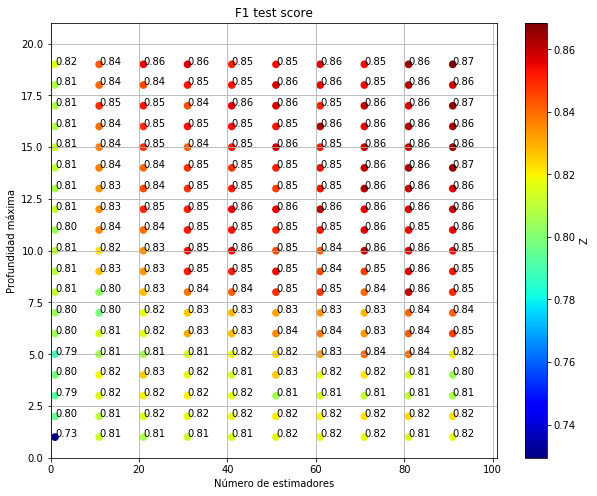

In [13]:
graph_ada_boost_range(estimator_params, depth_params, 1, 100, 20)

A diferencia de Random Forest, se necesita una cantidad menor de estimadores para alcanzar el puntaje máximo del conjunto de testing, y se mantiene la tendencia que indica que es la profundidad del árbol, o bien, los hiperparámetros de los algoritmos que se utilizan para el ensamblado los que impactan más en la calidad del aprendizaje

## Otra máquina de aprendizaje

De forma comparativa, se utilizará una SVM no lineal utilizando RBF para contrastar con los métodos anteriores

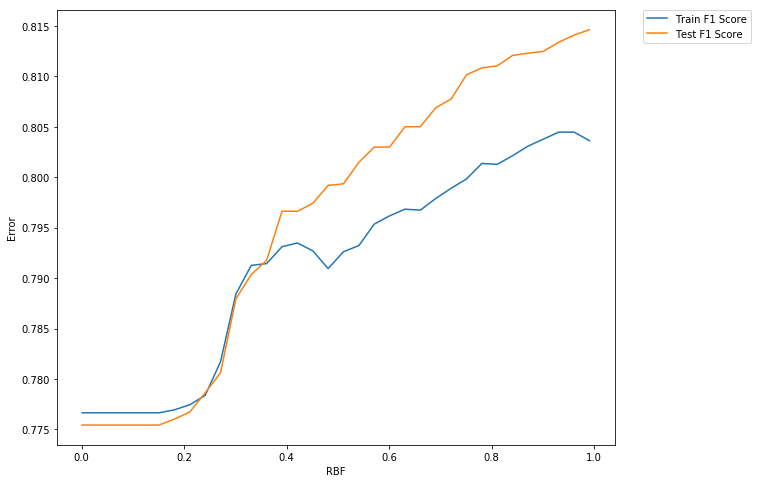

In [16]:
from sklearn.svm import SVC as SVM
from sklearn.metrics import accuracy_score
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score

def train_svm(param, Xtrain, Ytrain, Xtest, Ytest):
    # Entrenar el árbol
    model= SVM()
    model.set_params(C=param, kernel='rbf')
    model.fit(Xtrain, Ytrain)

    Ytrain_pred = model.predict(Xtrain)
    Ytest_pred = model.predict(Xtest)


    train_error = (1-accuracy_score(Ytrain, Ytrain_pred))
    test_error = (1-accuracy_score(Ytest, Ytest_pred))
    train_f1 = f1_score(Ytrain, Ytrain_pred)
    test_f2 = f1_score(Ytest, Ytest_pred)

    return (train_error, test_error, train_f1, test_f2)

def graph_svm_range(params):
    train_errors = []
    test_errors = []
    f1_train_errors = []
    f1_test_errors = []

    for depth in params:
        (train, test, f1train, f1test) = train_svm(depth, Xtrain, Ytrain, Xtest, Ytest)
        train_errors.append(train)
        test_errors.append(test)
        f1_train_errors.append(f1train)
        f1_test_errors.append(f1test)

    plt.figure(figsize=(10, 8))
    plt.plot(params, f1_train_errors, label="Train F1 Score")
    plt.plot(params, f1_test_errors, label="Test F1 Score")
    plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
    plt.xlabel('RBF')
    plt.ylabel('Error')
    plt.show()
    
params = np.arange(0.001, 1.0, 0.03)
graph_svm_range(params)

Se tiene que la SVM obtiene un puntaje de testing cercano a 0.795, para luego tener un puntaje de testing mayor al de entrenamiento que se puede considerar como overfitting. El accuracy es mucho menor que el puntaje obtenido por los ensambladores. En general, los ensambladores tendran un mejor desempeño que los algoritmos clásicos, siempre y cuando los algoritmos que se utilizan para el ensamblado funcionen correctamente en el conjunto de datos seleccionado.

## Selección de mejor modelo

Utilizando los mejores parámetros de cada máquina, se utiliza el conjunto de validación para seleccionar el mejor método. Se tiene entonces las siguientes 4 máquinas:

* Árbol de clasificación con profundidad 16
* Random forest con profunidad 16 y 60 estimadores
* Adaboost con profundidad 16 y 60 
* SVM lineal con kernel RBF y parámetro C=0.3

In [19]:
print(train_tree(16, Xtrain, Ytrain, Xvalidation, Yvalidation)[3])
print(train_random_forest(60, 16, Xtrain, Ytrain, Xvalidation, Yvalidation)[3])
print(train_ada_boost(60, 16, Xtrain, Ytrain, Xvalidation, Yvalidation)[3])
print(train_svm(0.3, Xtrain, Ytrain, Xvalidation, Yvalidation)[3])

0.793356130923
0.845827439887
0.841956726246
0.785797893094


Así, el mejor algoritmo corresponde a RandomForest

## Definición de importancia de atributos

Utilizando la métrica de feature_importances_ disponible en skearn, se obtiene el siguiente ranking de atributos:

In [20]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
import pandas as pd

model = RandomForestClassifier(n_estimators=10, max_depth=18,n_jobs=-1)
model.fit(Xtrain, Ytrain)
cols = model.feature_importances_
labels = df_randomized.columns.tolist()
joined = []
for i in range(0, len(df_randomized.columns)-1):
    joined.append((df_randomized.columns[i], model.feature_importances_[i]))
importance = pd.DataFrame(joined)

importance.sort_values(by=1, ascending=False)

,0,1
10,alcohol,0.135556
1,volatile acidity,0.103304
7,density,0.100295
5,free sulfur dioxide,0.088576
6,total sulfur dioxide,0.087166
4,chlorides,0.086531
8,pH,0.083005
3,residual sugar,0.082945
9,sulphates,0.079906
2,citric acid,0.074839


El atributo más importante corresponde a la cantidad de alcohol y la acidez volátil del vino para definir su calidad. Esto concuerda con la teoría de los vinos en dónde la acidez es uno de los factores más relevantes a la hora de degustar un vino. (Ver http://winefolly.com/review/wine-characteristics/ no ordenado por importancia)